In [28]:
!python -V

Python 3.9.18


In [29]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
# import pyarrow.parquet as pq
import requests

import mlflow


In [30]:
mlflow.set_tracking_uri("sqlite:///nyc_ride_duration.db")
mlflow.set_experiment("ride_duration")

<Experiment: artifact_location='/home/ramcharansatyasaitejapolisetti/MachineLearning/mlops/mlflow_project/mlruns/1', creation_time=1705772086651, experiment_id='1', last_update_time=1705772086651, lifecycle_stage='active', name='ride_duration', tags={}>

In [31]:
def read_dataframe(url):
    # url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet"
    response = requests.get(url)
    file_path = url.split("/")[-1]
    # "green_tripdata_2023-10.parquet"

    with open(file_path, "wb") as file:
        file.write(response.content)
    df = pd.read_parquet(file_path)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [32]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-11.parquet")

In [33]:
# df_train['categorical'] = df_train[['PULocationID', 'DOLocationID']]
# df_val['PU_DO'] = df_val[['PULocationID', 'DOLocationID']]
# df[categorical] = df[categorical].astype('str')

In [34]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df_train[categorical] = df_train[categorical].astype('str')
df_val[categorical] = df_val[categorical].astype('str')

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [35]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [36]:
type(y_val)

numpy.ndarray

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)


7.985611973845232

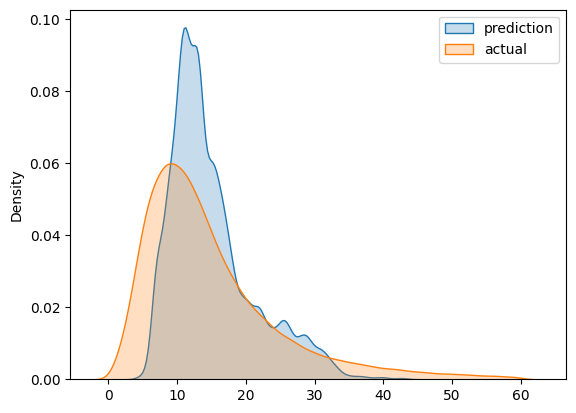

In [38]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [39]:
with open('model/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [40]:
rg = Ridge()
rg.fit(X_train, y_train)

y_pred = rg.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.983225977862511

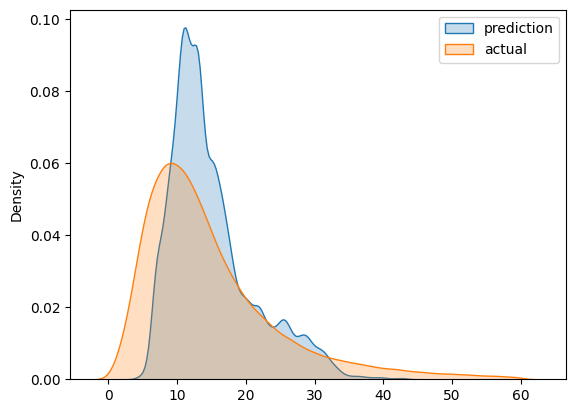

In [41]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [42]:
with open('model/ridge.bin', 'wb') as f_out:
    pickle.dump((dv, rg), f_out)

In [43]:
with mlflow.start_run():
    mlflow.set_tag('model', 'Lasso')
    mlflow.set_tag('version', 'v1')
    mlflow.set_tag('develper', 'ram_polisetti')

    alpha = 0.01
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)
    y_pred = ls.predict(X_val)
    
    mlflow.log_param('alpha', 0.01)
    mlflow.log_param('train_data_path', 'green_tripdata_2023-10.parquet')
    mlflow.log_param('val_data_path', 'green_tripdata_2023-11.parquet')
    mlflow.log_metric('rmse', root_mean_squared_error(y_val, y_pred))
    mlflow.sklearn.log_model(ls, 'model')
    
    root_mean_squared_error(y_val, y_pred)

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


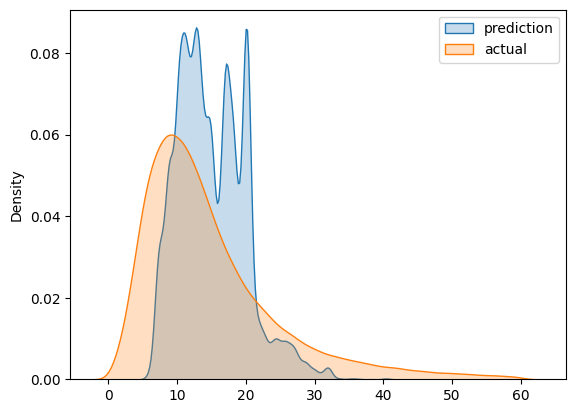

In [44]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [45]:
with open('model/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)

## Hyper Parameter Optimization

In [46]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope


In [50]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'XGBoost')
        for key, value in params.items():
            mlflow.log_param(key, value)
        mlflow.set_tag('develper', 'ram_polisetti')

        booster = xgb.train(params, 
                            dtrain = train, 
                            num_boost_round=1000,
                            evals=[(valid, 'validation')], 
                            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        
        # mlflow.log_param('train_data_path', 'green_tripdata_2023-10.parquet')
        # mlflow.log_param('val_data_path', 'green_tripdata_2023-11.parquet')
        mlflow.log_metric('rmse', rmse)
        mlflow.sklearn.log_model(ls, 'model')
        
    return {'loss': rmse, 'status': STATUS_OK}
        

In [51]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [52]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:40:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.47321                           
[1]	validation-rmse:9.09520                           
[2]	validation-rmse:8.75000                           
[3]	validation-rmse:8.43422                           
[4]	validation-rmse:8.14774                           
[5]	validation-rmse:7.88751                           
[6]	validation-rmse:7.65156                           
[7]	validation-rmse:7.43922                           
[8]	validation-rmse:7.24745                           
[9]	validation-rmse:7.07517                           
[10]	validation-rmse:6.92086                          
[11]	validation-rmse:6.78283                          
[12]	validation-rmse:6.65996                          
[13]	validation-rmse:6.55014                          
[14]	validation-rmse:6.45251                          
[15]	validation-rmse:6.36499                          
[16]	validation-rmse:6.28803                          
[17]	validation-rmse:6.22017                          
[18]	valid

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:40:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.08067                                                    
[1]	validation-rmse:7.03465                                                    
[2]	validation-rmse:6.47574                                                    
[3]	validation-rmse:6.17631                                                    
[4]	validation-rmse:6.04324                                                    
[5]	validation-rmse:5.97732                                                    
[6]	validation-rmse:5.95680                                                    
[7]	validation-rmse:5.94800                                                    
[8]	validation-rmse:5.95013                                                    
[9]	validation-rmse:5.95769                                                    
[10]	validation-rmse:5.96186                                                   
[11]	validation-rmse:5.97311                                                   
[12]	validation-rmse:5.97764            

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:41:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:9.23539                                                    
[1]	validation-rmse:8.67808                                                    
[2]	validation-rmse:8.20487                                                    
[3]	validation-rmse:7.80001                                                    
[4]	validation-rmse:7.46411                                                    
[5]	validation-rmse:7.17678                                                    
[6]	validation-rmse:6.93977                                                    
[7]	validation-rmse:6.74055                                                    
[8]	validation-rmse:6.57889                                                    
[9]	validation-rmse:6.44151                                                    
[10]	validation-rmse:6.33226                                                   
[11]	validation-rmse:6.24103                                                   
[12]	validation-rmse:6.16432            

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:41:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:6.16332                                                     
[1]	validation-rmse:6.09088                                                     
[2]	validation-rmse:6.17491                                                     
[3]	validation-rmse:6.18545                                                     
[4]	validation-rmse:6.20231                                                     
[5]	validation-rmse:6.21233                                                     
[6]	validation-rmse:6.23113                                                     
[7]	validation-rmse:6.25516                                                     
[8]	validation-rmse:6.26362                                                     
[9]	validation-rmse:6.27403                                                     
[10]	validation-rmse:6.28897                                                    
[11]	validation-rmse:6.29963                                                    
[12]	validation-rmse:6.30706

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:41:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.85092                                                     
[1]	validation-rmse:8.04449                                                     
[2]	validation-rmse:7.42243                                                     
[3]	validation-rmse:6.95266                                                     
[4]	validation-rmse:6.60636                                                     
[5]	validation-rmse:6.35003                                                     
[6]	validation-rmse:6.16521                                                     
[7]	validation-rmse:6.03364                                                     
[8]	validation-rmse:5.94223                                                     
[9]	validation-rmse:5.87751                                                     
[10]	validation-rmse:5.83219                                                    
[11]	validation-rmse:5.79927                                                    
[12]	validation-rmse:5.77411

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:41:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[2]	validation-rmse:5.88433                                                     
[3]	validation-rmse:5.86151                                                     
[4]	validation-rmse:5.84740                                                     
[5]	validation-rmse:5.83230                                                     
[6]	validation-rmse:5.80962                                                     
[7]	validation-rmse:5.81189                                                     
[8]	validation-rmse:5.80140                                                     
[9]	validation-rmse:5.79816                                                     
[10]	validation-rmse:5.78923                                                    
[11]	validation-rmse:5.77620                                                    
[12]	validation-rmse:5.76885                                                    
[13]	validation-rmse:5.75933                                                    
[14]	validation-rmse:5.75254

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:41:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:6.77889                                                     
[1]	validation-rmse:6.23327                                                     
[2]	validation-rmse:6.22264                                                     
[3]	validation-rmse:6.25786                                                     
[4]	validation-rmse:6.28157                                                     
[5]	validation-rmse:6.29805                                                     
[6]	validation-rmse:6.31117                                                     
[7]	validation-rmse:6.31723                                                     
[8]	validation-rmse:6.32531                                                     
[9]	validation-rmse:6.32859                                                     
[10]	validation-rmse:6.33412                                                    
[11]	validation-rmse:6.33468                                                    
[12]	validation-rmse:6.33688

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:41:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:9.27877                                                     
[1]	validation-rmse:8.74746                                                     
[2]	validation-rmse:8.28548                                                     
[3]	validation-rmse:7.88541                                                     
[4]	validation-rmse:7.54150                                                     
[5]	validation-rmse:7.24655                                                     
[6]	validation-rmse:6.99539                                                     
[7]	validation-rmse:6.78258                                                     
[8]	validation-rmse:6.60380                                                     
[9]	validation-rmse:6.45253                                                     
[10]	validation-rmse:6.32462                                                    
[11]	validation-rmse:6.22000                                                    
[12]	validation-rmse:6.13376

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:41:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.62208                                                     
[1]	validation-rmse:7.70328                                                     
[2]	validation-rmse:7.05441                                                     
[3]	validation-rmse:6.60880                                                     
[4]	validation-rmse:6.30681                                                     
[5]	validation-rmse:6.10863                                                     
[6]	validation-rmse:5.97454                                                     
[7]	validation-rmse:5.88632                                                     
[8]	validation-rmse:5.83183                                                     
[9]	validation-rmse:5.79531                                                     
[10]	validation-rmse:5.76803                                                    
[11]	validation-rmse:5.75085                                                    
[12]	validation-rmse:5.73830

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:41:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.18562                                                     
[1]	validation-rmse:7.13177                                                     
[2]	validation-rmse:6.51321                                                     
[3]	validation-rmse:6.16000                                                     
[4]	validation-rmse:5.97078                                                     
[5]	validation-rmse:5.86967                                                     
[6]	validation-rmse:5.81791                                                     
[7]	validation-rmse:5.78548                                                     
[8]	validation-rmse:5.76324                                                     
[9]	validation-rmse:5.75344                                                     
[10]	validation-rmse:5.74723                                                    
[11]	validation-rmse:5.74208                                                    
[12]	validation-rmse:5.73618

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:41:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.85340                                                      
[1]	validation-rmse:8.05329                                                      
[2]	validation-rmse:7.44640                                                      
[3]	validation-rmse:6.98838                                                      
[4]	validation-rmse:6.63715                                                      
[5]	validation-rmse:6.38584                                                      
[6]	validation-rmse:6.20379                                                      
[7]	validation-rmse:6.07103                                                      
[8]	validation-rmse:5.97925                                                      
[9]	validation-rmse:5.91093                                                      
[10]	validation-rmse:5.86802                                                     
[11]	validation-rmse:5.83875                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:42:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:6.09562                                                      
[1]	validation-rmse:6.03762                                                      
[2]	validation-rmse:6.04570                                                      
[3]	validation-rmse:6.06183                                                      
[4]	validation-rmse:6.07255                                                      
[5]	validation-rmse:6.10834                                                      
[6]	validation-rmse:6.11891                                                      
[7]	validation-rmse:6.13841                                                      
[8]	validation-rmse:6.13932                                                      
[9]	validation-rmse:6.15676                                                      
[10]	validation-rmse:6.17086                                                     
[11]	validation-rmse:6.18328                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:42:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:6.78036                                                      
[1]	validation-rmse:6.20793                                                      
[2]	validation-rmse:6.15048                                                      
[3]	validation-rmse:6.18611                                                      
[4]	validation-rmse:6.22135                                                      
[5]	validation-rmse:6.24561                                                      
[6]	validation-rmse:6.25835                                                      
[7]	validation-rmse:6.27375                                                      
[8]	validation-rmse:6.28116                                                      
[9]	validation-rmse:6.28580                                                      
[10]	validation-rmse:6.29267                                                     
[11]	validation-rmse:6.29803                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:42:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:9.10313                                                      
[1]	validation-rmse:8.44905                                                      
[2]	validation-rmse:7.91169                                                      
[3]	validation-rmse:7.46909                                                      
[4]	validation-rmse:7.11520                                                      
[5]	validation-rmse:6.82308                                                      
[6]	validation-rmse:6.59876                                                      
[7]	validation-rmse:6.41563                                                      
[8]	validation-rmse:6.27449                                                      
[9]	validation-rmse:6.16121                                                      
[10]	validation-rmse:6.07482                                                     
[11]	validation-rmse:6.00543                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:42:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[2]	validation-rmse:8.07627                                                      
[3]	validation-rmse:7.66040                                                      
[4]	validation-rmse:7.31694                                                      
[5]	validation-rmse:7.03491                                                      
[6]	validation-rmse:6.80535                                                      
[7]	validation-rmse:6.61896                                                      
[8]	validation-rmse:6.46416                                                      
[9]	validation-rmse:6.34185                                                      
[10]	validation-rmse:6.24101                                                     
[11]	validation-rmse:6.16085                                                     
[12]	validation-rmse:6.09617                                                     
[13]	validation-rmse:6.04052                                                     
[14]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:42:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:6.83839                                                      
[1]	validation-rmse:6.01189                                                      
[2]	validation-rmse:5.84181                                                      
[3]	validation-rmse:5.82396                                                      
[4]	validation-rmse:5.82399                                                      
[5]	validation-rmse:5.82590                                                      
[6]	validation-rmse:5.82666                                                      
[7]	validation-rmse:5.82856                                                      
[8]	validation-rmse:5.83686                                                      
[9]	validation-rmse:5.84222                                                      
[10]	validation-rmse:5.84368                                                     
[11]	validation-rmse:5.84516                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:42:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.18744                                                      
[1]	validation-rmse:7.13588                                                      
[2]	validation-rmse:6.52130                                                      
[3]	validation-rmse:6.18924                                                      
[4]	validation-rmse:6.01437                                                      
[5]	validation-rmse:5.93781                                                      
[6]	validation-rmse:5.90998                                                      
[7]	validation-rmse:5.89850                                                      
[8]	validation-rmse:5.90175                                                      
[9]	validation-rmse:5.91148                                                      
[10]	validation-rmse:5.92683                                                     
[11]	validation-rmse:5.93816                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:42:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[1]	validation-rmse:6.33712                                                      
[2]	validation-rmse:5.96247                                                      
[3]	validation-rmse:5.82647                                                      
[4]	validation-rmse:5.77509                                                      
[5]	validation-rmse:5.74695                                                      
[6]	validation-rmse:5.73557                                                      
[7]	validation-rmse:5.72130                                                      
[8]	validation-rmse:5.71024                                                      
[9]	validation-rmse:5.70072                                                      
[10]	validation-rmse:5.69781                                                     
[11]	validation-rmse:5.69427                                                     
[12]	validation-rmse:5.69283                                                     
[13]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:42:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:7.55670                                                      
[1]	validation-rmse:6.47350                                                      
[2]	validation-rmse:6.01746                                                      
[3]	validation-rmse:5.83600                                                      
[4]	validation-rmse:5.78178                                                      
[5]	validation-rmse:5.75964                                                      
[6]	validation-rmse:5.74658                                                      
[7]	validation-rmse:5.73563                                                      
[8]	validation-rmse:5.73125                                                      
[9]	validation-rmse:5.72908                                                      
[10]	validation-rmse:5.72295                                                     
[11]	validation-rmse:5.72478                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:42:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[1]	validation-rmse:5.81528                                                      
[2]	validation-rmse:5.78098                                                      
[3]	validation-rmse:5.76549                                                      
[4]	validation-rmse:5.75978                                                      
[5]	validation-rmse:5.76578                                                      
[6]	validation-rmse:5.76554                                                      
[7]	validation-rmse:5.76969                                                      
[8]	validation-rmse:5.77507                                                      
[9]	validation-rmse:5.77052                                                      
[10]	validation-rmse:5.77241                                                     
[11]	validation-rmse:5.76122                                                     
[12]	validation-rmse:5.76627                                                     
[13]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:43:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[5]	validation-rmse:8.29768                                                      
[6]	validation-rmse:8.09985                                                      
[7]	validation-rmse:7.91745                                                      
[8]	validation-rmse:7.75123                                                      
[9]	validation-rmse:7.59838                                                      
[10]	validation-rmse:7.45668                                                     
[11]	validation-rmse:7.32823                                                     
[12]	validation-rmse:7.21175                                                     
[13]	validation-rmse:7.10363                                                     
[14]	validation-rmse:7.00502                                                     
[15]	validation-rmse:6.91610                                                     
[16]	validation-rmse:6.83509                                                     
[17]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:43:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:9.33179                                                      
[1]	validation-rmse:8.84472                                                      
[2]	validation-rmse:8.41709                                                      
[3]	validation-rmse:8.04503                                                      
[4]	validation-rmse:7.72216                                                      
[5]	validation-rmse:7.43958                                                      
[6]	validation-rmse:7.19389                                                      
[7]	validation-rmse:6.98603                                                      
[8]	validation-rmse:6.80637                                                      
[9]	validation-rmse:6.65222                                                      
[10]	validation-rmse:6.51954                                                     
[11]	validation-rmse:6.40927                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:43:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:9.39348                                                      
[1]	validation-rmse:8.95119                                                      
[2]	validation-rmse:8.55680                                                      
[3]	validation-rmse:8.20909                                                      
[4]	validation-rmse:7.90112                                                      
[5]	validation-rmse:7.62683                                                      
[6]	validation-rmse:7.38761                                                      
[7]	validation-rmse:7.17375                                                      
[8]	validation-rmse:6.98907                                                      
[9]	validation-rmse:6.82402                                                      
[10]	validation-rmse:6.68374                                                     
[11]	validation-rmse:6.55828                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:43:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[6]	validation-rmse:6.75984                                                      
[7]	validation-rmse:6.61690                                                      
[8]	validation-rmse:6.50932                                                      
[9]	validation-rmse:6.42047                                                      
[10]	validation-rmse:6.35754                                                     
[11]	validation-rmse:6.30432                                                     
[12]	validation-rmse:6.26250                                                     
[13]	validation-rmse:6.23009                                                     
[14]	validation-rmse:6.20604                                                     
[15]	validation-rmse:6.18607                                                     
[16]	validation-rmse:6.16953                                                     
[17]	validation-rmse:6.15664                                                     
[18]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:43:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.99297                                                      
[1]	validation-rmse:8.27370                                                      
[2]	validation-rmse:7.69761                                                      
[3]	validation-rmse:7.24693                                                      
[4]	validation-rmse:6.88654                                                      
[5]	validation-rmse:6.61437                                                      
[6]	validation-rmse:6.39677                                                      
[7]	validation-rmse:6.23727                                                      
[8]	validation-rmse:6.11612                                                      
[9]	validation-rmse:6.02460                                                      
[10]	validation-rmse:5.95507                                                     
[11]	validation-rmse:5.89464                                                     
[12]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:44:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[7]	validation-rmse:6.20955                                                      
[8]	validation-rmse:6.14136                                                      
[9]	validation-rmse:6.09886                                                      
[10]	validation-rmse:6.06533                                                     
[11]	validation-rmse:6.04137                                                     
[12]	validation-rmse:6.02295                                                     
[13]	validation-rmse:6.00587                                                     
[14]	validation-rmse:5.99274                                                     
[15]	validation-rmse:5.98162                                                     
[16]	validation-rmse:5.96878                                                     
[17]	validation-rmse:5.96321                                                     
[18]	validation-rmse:5.95676                                                     
[19]	validation-

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:44:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[5]	validation-rmse:6.45206                                                     
[6]	validation-rmse:6.32719                                                     
[7]	validation-rmse:6.24228                                                     
[8]	validation-rmse:6.18507                                                     
[9]	validation-rmse:6.14658                                                     
[10]	validation-rmse:6.11606                                                    
[11]	validation-rmse:6.09012                                                    
[12]	validation-rmse:6.07198                                                    
[13]	validation-rmse:6.05438                                                    
[14]	validation-rmse:6.04336                                                    
[15]	validation-rmse:6.03009                                                    
[16]	validation-rmse:6.02258                                                    
[17]	validation-rmse:6.01372

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:44:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.66743                                                     
[1]	validation-rmse:7.77281                                                     
[2]	validation-rmse:7.13844                                                     
[3]	validation-rmse:6.68199                                                     
[4]	validation-rmse:6.37571                                                     
[5]	validation-rmse:6.16031                                                     
[6]	validation-rmse:6.02250                                                     
[7]	validation-rmse:5.92768                                                     
[8]	validation-rmse:5.86515                                                     
[9]	validation-rmse:5.82586                                                     
[10]	validation-rmse:5.79455                                                    
[11]	validation-rmse:5.77356                                                    
[12]	validation-rmse:5.76112

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:44:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[6]	validation-rmse:6.03149                                                     
[7]	validation-rmse:6.00656                                                     
[8]	validation-rmse:5.98106                                                     
[9]	validation-rmse:5.96389                                                     
[10]	validation-rmse:5.94866                                                    
[11]	validation-rmse:5.93736                                                    
[12]	validation-rmse:5.92613                                                    
[13]	validation-rmse:5.91453                                                    
[14]	validation-rmse:5.90504                                                    
[15]	validation-rmse:5.89826                                                    
[16]	validation-rmse:5.88982                                                    
[17]	validation-rmse:5.87498                                                    
[18]	validation-rmse:5.86805

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:44:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:7.71928                                                     
[1]	validation-rmse:6.62919                                                     
[2]	validation-rmse:6.12070                                                     
[3]	validation-rmse:5.90456                                                     
[4]	validation-rmse:5.80812                                                     
[5]	validation-rmse:5.77451                                                     
[6]	validation-rmse:5.75917                                                     
[7]	validation-rmse:5.74499                                                     
[8]	validation-rmse:5.74283                                                     
[9]	validation-rmse:5.73823                                                     
[10]	validation-rmse:5.73844                                                    
[11]	validation-rmse:5.73563                                                    
[12]	validation-rmse:5.73500

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:44:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:7.87209                                                     
[1]	validation-rmse:6.77871                                                     
[2]	validation-rmse:6.22351                                                     
[3]	validation-rmse:5.96598                                                     
[4]	validation-rmse:5.84994                                                     
[5]	validation-rmse:5.80681                                                     
[6]	validation-rmse:5.79080                                                     
[7]	validation-rmse:5.78616                                                     
[8]	validation-rmse:5.78435                                                     
[9]	validation-rmse:5.78328                                                     
[10]	validation-rmse:5.78534                                                    
[11]	validation-rmse:5.78452                                                    
[12]	validation-rmse:5.78919

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:44:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[3]	validation-rmse:5.95985                                                     
[4]	validation-rmse:5.90021                                                     
[5]	validation-rmse:5.87716                                                     
[6]	validation-rmse:5.86152                                                     
[7]	validation-rmse:5.84490                                                     
[8]	validation-rmse:5.82900                                                     
[9]	validation-rmse:5.81591                                                     
[10]	validation-rmse:5.80804                                                    
[11]	validation-rmse:5.79738                                                    
[12]	validation-rmse:5.78421                                                    
[13]	validation-rmse:5.76958                                                    
[14]	validation-rmse:5.76183                                                    
[15]	validation-rmse:5.75331

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:44:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[1]	validation-rmse:7.44909                                                     
[2]	validation-rmse:6.81601                                                     
[3]	validation-rmse:6.41038                                                     
[4]	validation-rmse:6.16685                                                     
[5]	validation-rmse:6.01046                                                     
[6]	validation-rmse:5.91637                                                     
[7]	validation-rmse:5.85294                                                     
[8]	validation-rmse:5.81495                                                     
[9]	validation-rmse:5.78611                                                     
[10]	validation-rmse:5.76594                                                    
[11]	validation-rmse:5.75119                                                    
[12]	validation-rmse:5.73997                                                    
[13]	validation-rmse:5.73061

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:6.37392                                                     
[1]	validation-rmse:5.86288                                                     
[2]	validation-rmse:5.79126                                                     
[3]	validation-rmse:5.77622                                                     
[4]	validation-rmse:5.78301                                                     
[5]	validation-rmse:5.78046                                                     
[6]	validation-rmse:5.77632                                                     
[7]	validation-rmse:5.78201                                                     
[8]	validation-rmse:5.79174                                                     
[9]	validation-rmse:5.80212                                                     
[10]	validation-rmse:5.80542                                                    
[11]	validation-rmse:5.80578                                                    
[12]	validation-rmse:5.80760

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:7.90168                                                     
[1]	validation-rmse:6.83348                                                     
[2]	validation-rmse:6.31723                                                     
[3]	validation-rmse:6.08739                                                     
[4]	validation-rmse:5.99495                                                     
[5]	validation-rmse:5.98007                                                     
[6]	validation-rmse:5.99269                                                     
[7]	validation-rmse:6.01264                                                     
[8]	validation-rmse:6.03782                                                     
[9]	validation-rmse:6.05265                                                     
[10]	validation-rmse:6.07081                                                    
[11]	validation-rmse:6.07869                                                    
[12]	validation-rmse:6.08444

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:9.42695                                                     
[1]	validation-rmse:9.01127                                                     
[2]	validation-rmse:8.63569                                                     
[3]	validation-rmse:8.29759                                                     
[4]	validation-rmse:7.99655                                                     
[5]	validation-rmse:7.72566                                                     
[6]	validation-rmse:7.48582                                                     
[7]	validation-rmse:7.27005                                                     
[8]	validation-rmse:7.08209                                                     
[9]	validation-rmse:6.91281                                                     
[10]	validation-rmse:6.76458                                                    
[11]	validation-rmse:6.63023                                                    
[12]	validation-rmse:6.51515

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[1]	validation-rmse:6.47905                                                     
[2]	validation-rmse:6.06549                                                     
[3]	validation-rmse:5.89900                                                     
[4]	validation-rmse:5.83296                                                     
[5]	validation-rmse:5.80265                                                     
[6]	validation-rmse:5.78183                                                     
[7]	validation-rmse:5.76704                                                     
[8]	validation-rmse:5.75335                                                     
[9]	validation-rmse:5.74475                                                     
[10]	validation-rmse:5.73976                                                    
[11]	validation-rmse:5.73583                                                    
[12]	validation-rmse:5.73416                                                    
[13]	validation-rmse:5.72774

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[3]	validation-rmse:6.51723                                                     
[4]	validation-rmse:6.26904                                                     
[5]	validation-rmse:6.11370                                                     
[6]	validation-rmse:6.01506                                                     
[7]	validation-rmse:5.95077                                                     
[8]	validation-rmse:5.91088                                                     
[9]	validation-rmse:5.87871                                                     
[10]	validation-rmse:5.86399                                                    
[11]	validation-rmse:5.84732                                                    
[12]	validation-rmse:5.83614                                                    
[13]	validation-rmse:5.82262                                                    
[14]	validation-rmse:5.81342                                                    
[15]	validation-rmse:5.80511

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.80180                                                     
[1]	validation-rmse:7.97746                                                     
[2]	validation-rmse:7.36152                                                     
[3]	validation-rmse:6.91154                                                     
[4]	validation-rmse:6.58551                                                     
[5]	validation-rmse:6.35802                                                     
[6]	validation-rmse:6.20000                                                     
[7]	validation-rmse:6.09502                                                     
[8]	validation-rmse:6.02164                                                     
[9]	validation-rmse:5.97055                                                     
[10]	validation-rmse:5.93945                                                    
[11]	validation-rmse:5.92420                                                    
[12]	validation-rmse:5.91340

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:6.37214                                                     
[1]	validation-rmse:5.88116                                                     
[2]	validation-rmse:5.80276                                                     
[3]	validation-rmse:5.77707                                                     
[4]	validation-rmse:5.76900                                                     
[5]	validation-rmse:5.76748                                                     
[6]	validation-rmse:5.76120                                                     
[7]	validation-rmse:5.74619                                                     
[8]	validation-rmse:5.74274                                                     
[9]	validation-rmse:5.74311                                                     
[10]	validation-rmse:5.75022                                                    
[11]	validation-rmse:5.75364                                                    
[12]	validation-rmse:5.75435

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.71988                                                     
[1]	validation-rmse:7.84500                                                     
[2]	validation-rmse:7.20370                                                     
[3]	validation-rmse:6.74240                                                     
[4]	validation-rmse:6.41458                                                     
[5]	validation-rmse:6.19096                                                     
[6]	validation-rmse:6.03835                                                     
[7]	validation-rmse:5.93432                                                     
[8]	validation-rmse:5.86277                                                     
[9]	validation-rmse:5.81653                                                     
[10]	validation-rmse:5.78687                                                    
[11]	validation-rmse:5.76571                                                    
[12]	validation-rmse:5.75493

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[3]	validation-rmse:6.01975                                                     
[4]	validation-rmse:6.00102                                                     
[5]	validation-rmse:5.99238                                                     
[6]	validation-rmse:5.97152                                                     
[7]	validation-rmse:5.95884                                                     
[8]	validation-rmse:5.94707                                                     
[9]	validation-rmse:5.92578                                                     
[10]	validation-rmse:5.92636                                                    
[11]	validation-rmse:5.91948                                                    
[12]	validation-rmse:5.92074                                                    
[13]	validation-rmse:5.91431                                                    
[14]	validation-rmse:5.90700                                                    
[15]	validation-rmse:5.90211

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:45:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:7.09648                                                     
[1]	validation-rmse:6.16406                                                     
[2]	validation-rmse:5.88453                                                     
[3]	validation-rmse:5.80205                                                     
[4]	validation-rmse:5.76803                                                     
[5]	validation-rmse:5.74172                                                     
[6]	validation-rmse:5.72076                                                     
[7]	validation-rmse:5.71021                                                     
[8]	validation-rmse:5.70523                                                     
[9]	validation-rmse:5.70087                                                     
[10]	validation-rmse:5.69545                                                    
[11]	validation-rmse:5.69386                                                    
[12]	validation-rmse:5.69422

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:46:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:9.53983                                                     
[1]	validation-rmse:9.21874                                                     
[2]	validation-rmse:8.92162                                                     
[3]	validation-rmse:8.64825                                                     
[4]	validation-rmse:8.39539                                                     
[5]	validation-rmse:8.16384                                                     
[6]	validation-rmse:7.95150                                                     
[7]	validation-rmse:7.75770                                                     
[8]	validation-rmse:7.58019                                                     
[9]	validation-rmse:7.41855                                                     
[10]	validation-rmse:7.27165                                                    
[11]	validation-rmse:7.13680                                                    
[12]	validation-rmse:7.01802

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:46:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.18019                                                     
[1]	validation-rmse:7.12902                                                     
[2]	validation-rmse:6.52017                                                     
[3]	validation-rmse:6.18440                                                     
[4]	validation-rmse:6.01560                                                     
[5]	validation-rmse:5.93509                                                     
[6]	validation-rmse:5.91529                                                     
[7]	validation-rmse:5.91528                                                     
[8]	validation-rmse:5.92314                                                     
[9]	validation-rmse:5.93800                                                     
[10]	validation-rmse:5.96316                                                    
[11]	validation-rmse:5.97918                                                    
[12]	validation-rmse:5.99115

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:46:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:9.11749                                                     
[1]	validation-rmse:8.47350                                                     
[2]	validation-rmse:7.93591                                                     
[3]	validation-rmse:7.49721                                                     
[4]	validation-rmse:7.13359                                                     
[5]	validation-rmse:6.84063                                                     
[6]	validation-rmse:6.60412                                                     
[7]	validation-rmse:6.41549                                                     
[8]	validation-rmse:6.26645                                                     
[9]	validation-rmse:6.15171                                                     
[10]	validation-rmse:6.05909                                                    
[11]	validation-rmse:5.98920                                                    
[12]	validation-rmse:5.93240

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:46:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:9.24525                                                     
[1]	validation-rmse:8.68787                                                     
[2]	validation-rmse:8.21209                                                     
[3]	validation-rmse:7.79937                                                     
[4]	validation-rmse:7.45085                                                     
[5]	validation-rmse:7.15772                                                     
[6]	validation-rmse:6.90930                                                     
[7]	validation-rmse:6.70266                                                     
[8]	validation-rmse:6.52823                                                     
[9]	validation-rmse:6.38281                                                     
[10]	validation-rmse:6.26383                                                    
[11]	validation-rmse:6.16408                                                    
[12]	validation-rmse:6.08279

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:46:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.02921                                                     
[1]	validation-rmse:6.96850                                                     
[2]	validation-rmse:6.41007                                                     
[3]	validation-rmse:6.11458                                                     
[4]	validation-rmse:5.97557                                                     
[5]	validation-rmse:5.91302                                                     
[6]	validation-rmse:5.88302                                                     
[7]	validation-rmse:5.86539                                                     
[8]	validation-rmse:5.85510                                                     
[9]	validation-rmse:5.85466                                                     
[10]	validation-rmse:5.85189                                                    
[11]	validation-rmse:5.84971                                                    
[12]	validation-rmse:5.84812

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:47:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:7.70778                                                     
[1]	validation-rmse:6.60764                                                     
[2]	validation-rmse:6.10495                                                     
[3]	validation-rmse:5.89953                                                     
[4]	validation-rmse:5.81557                                                     
[5]	validation-rmse:5.78198                                                     
[6]	validation-rmse:5.76614                                                     
[7]	validation-rmse:5.75828                                                     
[8]	validation-rmse:5.75398                                                     
[9]	validation-rmse:5.75212                                                     
[10]	validation-rmse:5.75309                                                    
[11]	validation-rmse:5.75150                                                    
[12]	validation-rmse:5.75197

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:47:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now dep

[0]	validation-rmse:8.53472
[1]	validation-rmse:7.59429                                                     
[2]	validation-rmse:6.96951                                                     
[3]	validation-rmse:6.54483                                                     
[4]	validation-rmse:6.27889                                                     
[5]	validation-rmse:6.10776                                                     
[6]	validation-rmse:5.99334                                                     
[7]	validation-rmse:5.91918                                                     
[8]	validation-rmse:5.87540                                                     
[9]	validation-rmse:5.83355                                                     
[10]	validation-rmse:5.80905                                                    
[11]	validation-rmse:5.79582                                                    
[12]	validation-rmse:5.77720                                                    


/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

